# Sprint
## 深層学習スクラッチ ディープニューラルネットワーク


## 1.このSprintについて

### Sprintの目的
- スクラッチを通してニューラルネットワークの発展的内容を理解する

### どのように学ぶか
スクラッチで作成したニューラルネットワークの実装を拡張していきます。

## 2.ディープニューラルネットワークスクラッチ

前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。


このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。


名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。


### 層などのクラス化
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。


**手を加える箇所**


- 層の数
- 層の種類（今後畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。


実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。



**《サンプルコード1》**

ScratchDeepNeuralNetrowkClassifierのfitメソッド内

```python
# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数
optimizer = SGD(self.lr)
self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
self.activation1 = Tanh()
self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
self.activation2 = Tanh()
self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
self.activation3 = Softmax()
```

**《サンプルコード2》**

イテレーションごとのフォワード

```python
A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1)
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)
```

**《サンプルコード3》**

イテレーションごとのバックワード

```python
dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
```

In [1]:
# import modules
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### 【問題1】
#### 全結合層のクラス化
全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンス`self`を渡すこともできます。これを利用して`self.optimizer.update(self)`という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。

In [2]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス

    Attribute
    ---------
    self.W : ndarray(n_nodes1, n_nodes2)
      重み
    self.B : ndarray(n_node2,)
      バイアス
    self.H : float
      前イテレーションまでの勾配の二乗和
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.HW = np.zeros(self.W.shape)
        self.HB = np.zeros(self.B.shape)
        pass

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.Z_prev = X

        A = X@self.W + self.B

        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        # 更新
        dZ = self.optimizer.update(self, dA)

        return dZ

### 【問題2】
#### 初期化方法のクラス化
初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [3]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros((n_nodes2,))

        return B

### 【問題3】
#### 最適化手法のクラス化
最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときに`self.optimizer.update(self)`のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [4]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dA):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        dB = np.mean(dA, axis=0)
        dW = (layer.Z_prev.T@dA) / dA.shape[0]
        dZ = dA@layer.W.T

        layer.B = layer.B - self.lr*dB
        layer.W = layer.W - self.lr*dW

        return dZ

### 【問題4】
#### 活性化関数のクラス化
活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [5]:
class Softmax:
    """
    ソフトマックス関数

    Attribute
    ----------
    self.loss
        出力の交差エントロピー誤差
    """
    def forward(self, A):
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        
        return Z

    def backward(self, Z, Y):
        dA = Z - Y
        self.loss = self.calc_cross_entropy_loss(Y, Z)

        return dA
    
    def calc_cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]

        cross_entropy_loss = (-1 * (np.sum(y_true*np.log(y_pred)))) / n_samples
 
        return cross_entropy_loss

class Sigmoid:
    """
    シグモイド関数

    Attribute
    ----------
    self.A
        活性化関数の入力
    """
    def forward(self, A):
        self.A = A
        Z = 1 / (1+np.exp(-A))
        
        return Z

    def backward(self, dZ):
        dA = dZ * ((1 - self.A) * (self.A))

        return dA

class Tanh:
    """
    tanh関数

    Attribute
    ----------
    self.A
        活性化関数の入力
    """
    def forward(self, A):
        self.A = A
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        
        return Z

    def backward(self, dZ):
        dA = dZ * (1 - self.A**2)

        return dA

### 発展的要素
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

### 【問題5】
#### ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。

$$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

$x$: ある特徴量。スカラー


実装上は`np.maximum`を使い配列に対してまとめて計算が可能です。


[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html)


一方、バックプロパゲーションのための$x$に関する$f(x)$の微分は以下のようになります。

$$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

数学的には微分可能ではないですが、$x=0$のとき$0$とすることで対応しています。


フォワード時の$x$の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [6]:
class ReLU:
    """
    ReLU関数

    Attribute
    ----------
    self.A
        活性化関数の入力
    """
    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        
        return Z

    def backward(self, dZ):
        dA = dZ * np.where(self.A > 0, 1, 0)

        return dA

### 【問題6】
#### 重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。

### Xavierの初期値
Xavierの初期値における標準偏差$\sigma$は次の式で求められます。

$$
\sigma = \frac{1}{\sqrt{n}}
$$

$n$ : 前の層のノード数


**《論文》**


[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)


### Heの初期値
Heの初期値における標準偏差$\sigma$は次の式で求められます。

$$
\sigma = \sqrt{\frac{2}{n}}
$$

$n$ : 前の層のノード数


**《論文》**


[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf)

In [7]:
class XavierInitializer:
    """
    Xavierの初期値
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    
    Attributes
    ----------
    self.sigma
      ガウス分布の標準偏差
    """
    def __init__(self, n_nodes1):
        self.sigma = 1 / np.sqrt(n_nodes1)
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
          重み
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
          バイアス
        """
        B = np.zeros((n_nodes2,))

        return B

class HeInitializer:
    """
    Heの初期値
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数

    Attributes
    ----------
    self.sigma
      ガウス分布の標準偏差
    """
    def __init__(self, n_nodes1):
        self.sigma = np.sqrt(2/n_nodes1)
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
          重み
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
          バイアス
        """
        B = np.zeros((n_nodes2,))

        return B

### 【問題7】
#### 最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である**AdaGrad**のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$に関する損失$L$の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$に関する損失$L$の勾配


$E()$ : ミニバッチ方向にベクトルの平均を計算


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。


更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和$H$を保存しておき、その分だけ学習率を小さくします。


学習率は重み一つひとつに対して異なることになります。

$$
H_i^{\prime} = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）


$H_i^{\prime}$ : 更新した$H_i$


**《論文》**


[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

In [8]:
class AdaGrad:
    """
    AdaGrad法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dA):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        # calc partial
        dB = np.mean(dA, axis=0)
        dW = (layer.Z_prev.T@dA) / dA.shape[0]
        dZ = dA@layer.W.T

        # update HB, HW
        layer.HB = layer.HB + dB**2
        layer.HW = layer.HW + dW**2

        # update W and B
        layer.B = layer.B - self.lr*(1/(np.sqrt(layer.HB+1e-7)))*dB
        layer.W = layer.W - self.lr*(1/(np.sqrt(layer.HW+1e-7)))*dW

        return dZ

### 【問題8】
#### クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [9]:
class ScratchDeepNeuralNetworkClassifier:
    """
    多層ニューラルネットワーク分類器

    Parameters
    ----------
    alpha : float
        学習率
    sigma : float
        ガウス分布の標準偏差
    batch_size : int
        バッチのサイズ
    epoch : int
        エポック数

    Attributes
    ----------
    self.loss : list
        交差エントロピー誤差（訓練データ）
    self.val_loss : list
        交差エントロピー誤差（バリデーションデータ)
    """
    def __init__(self, alpha=0.01, sigma=0.01, batch_size=20, epoch=1, verbose=True, optimizer='SGD', acitivator='ReLU', n_nodes=[400, 200, 10]):
        self.alpha = alpha
        self.sigma = sigma
        self.batch_size = batch_size
        self.epoch = epoch
        self.verbose = verbose
        self.optimizer_name = optimizer
        self.activator_name = acitivator
        self.n_nodes = n_nodes

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # def optimizer
        if self.optimizer_name == 'SGD':
            optimizer = SGD(self.alpha)
        elif self.optimizer_name == 'AdaGrad':
            optimizer = AdaGrad(self.alpha)
        else:
            raise ValueError(f'no such optimizer named "{self.optimizer_name}"')

        # def layers
        self.FCs = []
        self.activations = []
        self.n_features = [X.shape[1]]
        
        for i, (n_nodes1, n_nodes2) in enumerate(zip(self.n_features+self.n_nodes[:-1], self.n_nodes)):
            if i+1 != len(self.n_nodes):
                # def initializer / activator
                if self.activator_name == 'ReLU':
                    initializer = HeInitializer(n_nodes1)
                    self.activations.append(ReLU())
                elif self.activator_name == 'Sigmoid':
                    initializer = XavierInitializer(n_nodes1)
                    self.activations.append(Sigmoid())
                elif self.activator_name == 'Tanh':
                    initializer = XavierInitializer(n_nodes1)
                    self.activations.append(Tanh())
                else:
                    raise ValueError(f'no such activator named "{self.activator_name}"')

                # def layer
                self.FCs.append(FC(n_nodes1, n_nodes2, initializer, optimizer))
            # last layer
            else:
                # def initializer
                if self.activator_name == 'ReLU':
                    initializer = HeInitializer(n_nodes1)
                elif self.activator_name == 'Sigmoid':
                    initializer = XavierInitializer(n_nodes1)
                elif self.activator_name == 'Tanh':
                    initializer = XavierInitializer(n_nodes1)
                else:
                    raise ValueError(f'no such activator named "{self.activator_name}"')

                # def activator
                self.activations.append(Softmax())

                # def layer
                self.FCs.append(FC(n_nodes1, n_nodes2, initializer, optimizer))
        
        ## one-hot encoding
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(y[:, np.newaxis])
        if y_val is not None:
            y_val_one_hot = enc.transform(y_val[:, np.newaxis])

        ## loss list
        self.loss = []
        self.val_loss = []

        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print('start learning')

        start_time = time.time()

        # learning
        for e in range(self.epoch):
            print(f'start epoch {e+1}')

            ## mini_batch
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=e)

            ## loss list
            self.loss.append([])

            for i, (mini_X_train, mini_y_train) in enumerate(get_mini_batch):
                ## one-hot encoding
                mini_y_train_one_hot = enc.transform(mini_y_train[:, np.newaxis])
                
                ## forward propagation
                A = []
                Z = []
                for j in range(len(self.FCs)):
                    ## calc A
                    if j == 0:
                        A.append(self.FCs[j].forward(mini_X_train))
                    else:
                        A.append(self.FCs[j].forward(Z[-1]))
                    ## calc Z
                    Z.append(self.activations[j].forward(A[-1]))
                            
                ## update weight, bias
                ## append loss
                dA = []
                dZ = []
                for j in range(1, len(self.FCs)+1):
                    if j == 1:
                        ## backward
                        dA.append(self.activations[-j].backward(Z[-1], mini_y_train_one_hot))
                        ## loss
                        self.loss[e].append(self.activations[-j].loss)
                    else:
                        ## backward
                        dA.append(self.activations[-j].backward(dZ[-1]))
                    dZ.append(self.FCs[-j].backward(dA[-1]))

                ## print progress
                if self.verbose:
                    print(f'\r{i+1}/{len(get_mini_batch)} loop finished', end='')

            ## validation
            if (X_val is not None) and (y_val is not None):
                ### prediction
                tmp_A = []
                tmp_Z = []
                for j in range(len(self.FCs)):
                    ## calc A
                    if j == 0:
                        tmp_A.append(self.FCs[j].forward(X_val))
                    else:
                        tmp_A.append(self.FCs[j].forward(tmp_Z[-1]))
                    ## calc Z
                    tmp_Z.append(self.activations[j].forward(tmp_A[-1]))
                ### append loss
                self.val_loss.append(self.activations[-1].calc_cross_entropy_loss(y_val_one_hot, tmp_Z[-1]))

            if self.verbose:
                print(' : Complete!!')
            if y_val is not None:
                print(f'epoch {e+1} valid loss: {self.val_loss[-1]}')

        end_time = time.time()
        elapsed_time = end_time - start_time

        # output loss
        print(f'last train loss: {self.loss[-1][-1]}')

        print(f'Done! elapsed time: {elapsed_time:.5f}s')

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        ## forward propagation
        A = []
        Z = []
        for i in range(len(self.FCs)):
            ## calc A
            if i == 0:
                A.append(self.FCs[i].forward(X))
            else:
                A.append(self.FCs[i].forward(Z[-1]))
            ## calc Z
            Z.append(self.activations[i].forward(A[-1]))
        
        return np.argmax(Z[-1], axis=1)

In [10]:
# Sprint9から拝借
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 【問題9】
#### 学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [11]:
def plot_loss(model):
    loss = model.loss
    val_loss = model.val_loss

    %matplotlib inline

    # エポック単位
    for i in range(model.epoch):
        fig = plt.figure(figsize=(12, 4))
        ax1 = fig.add_subplot(121)
        plt.title(f'cross entropy loss: epoch{i+1}')
        plt.plot(range(len(loss[i])), loss[i], label='loss')
        plt.legend()

        ## 移動平均
        ax2 = fig.add_subplot(122)
        rolling_loss = []
        rolling_val_loss = []
        window_size = 20
        for j in range(len(loss[i])-window_size):
            rolling_loss.append(sum(loss[i][j:j+window_size])/window_size)
        plt.title(f'rolling loss: epoch{i+1}')  
        plt.plot(range(len(rolling_loss)), rolling_loss, label='rolling loss')
        plt.legend()
        plt.show()

    # バリデーション
    if len(val_loss) > 0:
        plt.title('cross entropy loss: validation')
        plt.plot(range(1, len(val_loss)+1), val_loss, label='val_loss')
        plt.legend()
        plt.show()
    
    # 全体
    plt.title('cross entropy loss: all')
    plt.plot(range(len(sum(loss, []))), sum(loss, []), label='loss')
    plt.legend()
    plt.show()

In [12]:
def true_false_visualize(y_pred, X_val, y_val):
    """
    誤分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

    Parameters:
    ----------
    y_pred : 推定値のndarray (n_samples,)
    y_val : 検証データの正解ラベル(n_samples,)
    X_val : 検証データの特徴量（n_samples, n_features)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    num = 81 # いくつ表示するか
    true_false = y_pred==y_val
    false_list = np.where(true_false==False)[0].astype(np.int)
    if false_list.shape[0] < num:
        num = false_list.shape[0]
    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
        ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
        ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

In [13]:
# データのロード
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape)
print(X_test.shape)

(48000, 784)
(12000, 784)
(10000, 784)


In [14]:
# 学習
params = {
    'alpha':0.005,
    'sigma':1,
    'batch_size':100,
    'epoch':10,
    'verbose':True,
    'optimizer':'AdaGrad',
    'acitivator':'ReLU',
    'n_nodes':[600, 400, 200, 100, 10]
}
scratchDNN = ScratchDeepNeuralNetworkClassifier(**params)
scratchDNN.fit(X_train, y_train, X_val, y_val)

start learning
start epoch 1
480/480 loop finished : Complete!!
epoch 1 valid loss: 0.11975741021631611
start epoch 2
480/480 loop finished : Complete!!
epoch 2 valid loss: 0.09436714390210123
start epoch 3
480/480 loop finished : Complete!!
epoch 3 valid loss: 0.08741067014639693
start epoch 4
480/480 loop finished : Complete!!
epoch 4 valid loss: 0.08216448827581496
start epoch 5
480/480 loop finished : Complete!!
epoch 5 valid loss: 0.07800707616452299
start epoch 6
480/480 loop finished : Complete!!
epoch 6 valid loss: 0.07575943564719766
start epoch 7
480/480 loop finished : Complete!!
epoch 7 valid loss: 0.07645025958186404
start epoch 8
480/480 loop finished : Complete!!
epoch 8 valid loss: 0.0749927129856393
start epoch 9
480/480 loop finished : Complete!!
epoch 9 valid loss: 0.07490512385834425
start epoch 10
480/480 loop finished : Complete!!
epoch 10 valid loss: 0.0764480756363237
last train loss: 0.002464817139622617
Done! elapsed time: 294.73683s


In [19]:
from sklearn.metrics import accuracy_score
y_test_pred = scratchDNN.predict(X_test)
print(y_test_pred)
print(y_test)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred)}')

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
Accuracy: 0.9798


In [20]:
from sklearn.metrics import confusion_matrix
conf_m = confusion_matrix(y_test, y_test_pred) 
print(conf_m)
sample_sum = np.sum(conf_m, axis=1)
for i in range(conf_m.shape[0]):
    correct = conf_m[i][i]
    incorrect = sample_sum[i] - correct
    print(f'{i}: {correct}:{incorrect} {correct/sample_sum[i]:.2%}')

[[ 971    0    1    1    1    2    1    1    2    0]
 [   0 1127    3    1    0    1    2    0    1    0]
 [   3    0 1007    3    2    0    2    6    9    0]
 [   0    0    6  987    0    4    0    4    5    4]
 [   0    1    6    1  966    0    1    1    1    5]
 [   2    0    1    8    2  865    5    1    6    2]
 [   4    2    0    1    3    3  945    0    0    0]
 [   1    5    8    2    1    0    0 1002    3    6]
 [   3    0    2    4    0    3    2    3  953    4]
 [   2    3    0    5    7    4    2    4    7  975]]
0: 971:9 99.08%
1: 1127:8 99.30%
2: 1007:25 97.58%
3: 987:23 97.72%
4: 966:16 98.37%
5: 865:27 96.97%
6: 945:13 98.64%
7: 1002:26 97.47%
8: 953:21 97.84%
9: 975:34 96.63%


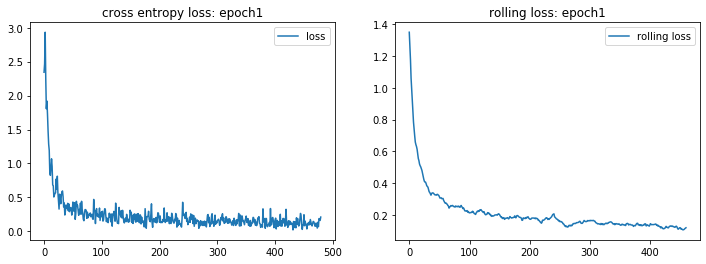

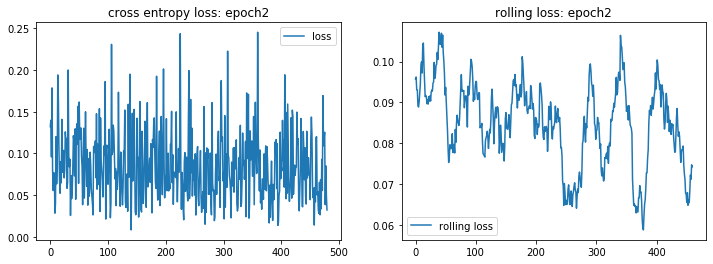

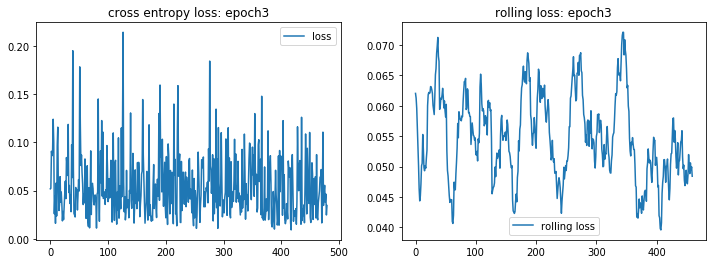

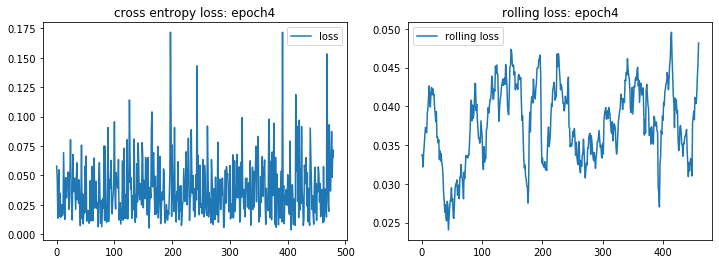

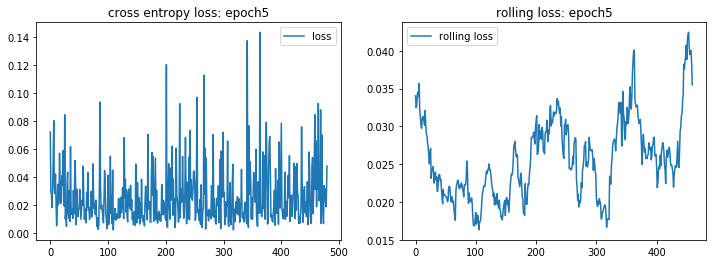

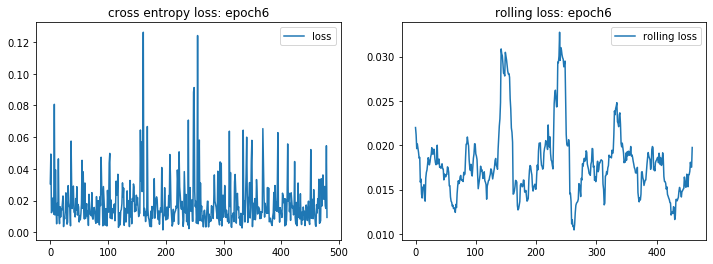

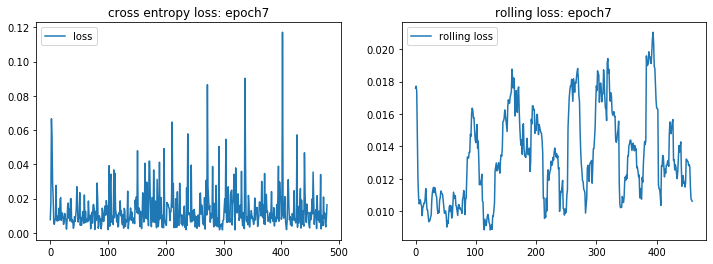

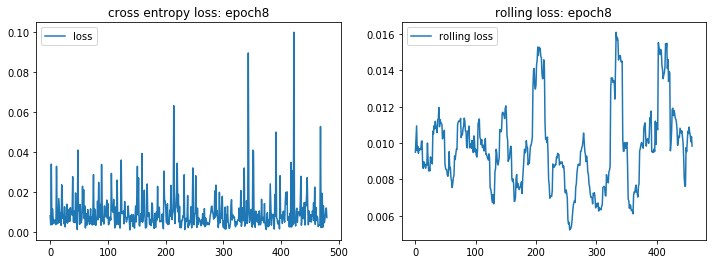

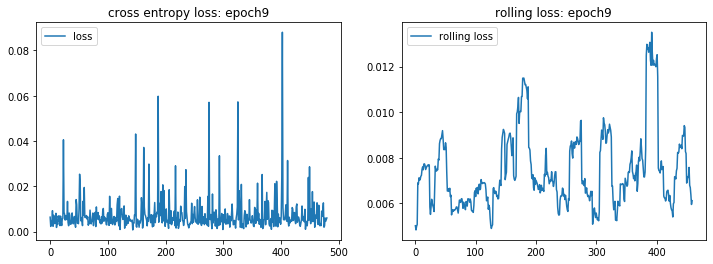

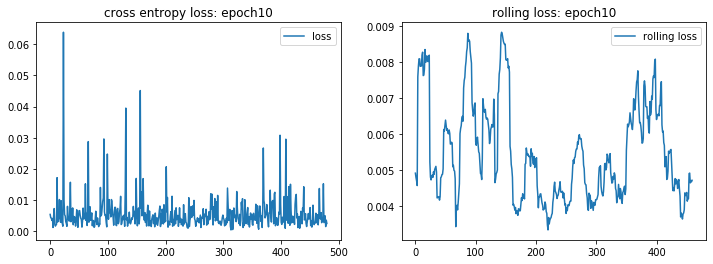

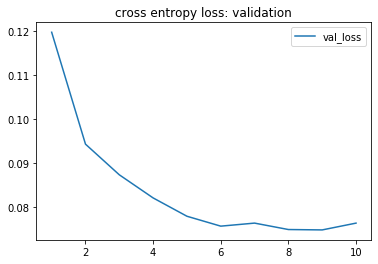

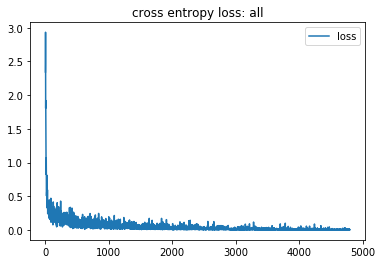

In [21]:
plot_loss(scratchDNN)

テストデータの正解率はおよそ0.98となり、単純なガウス分布の初期化やほかの活性化関数・最適化手法を使った場合よりも精度を上げることができた。

予測結果を見ると、6エポックからはほぼ収束しており、9エポック付近からは若干だが過学習の兆候がみられる。NNは過学習しやすいアルゴリズムであるため層数・バッチサイズ・epoch数などを慎重に調整する必要があることが分かる。



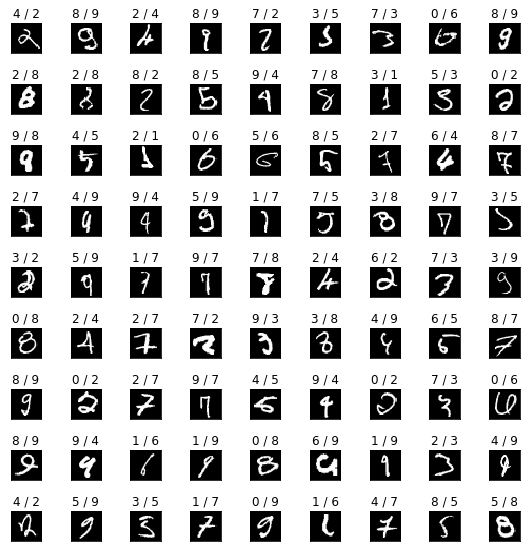

In [22]:
true_false_visualize(y_test_pred, X_test, y_test)

3層NNの傾向と近く、掠れた字、潰れた字や英語圏の7（横棒付き）などが目立つ。

